In [1]:
! pip install -U nilearn
! pip install segmentation-models-3D
! pip install classification-models-3D
! pip install visualkeras
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import os
#General Libraries

import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Model libraries
import tensorflow as tf
from tensorflow import keras
import visualkeras
from keras.utils.vis_utils import plot_model
import segmentation_models_3D as sm
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

TRAIN_DATASET_PATH='/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 61.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.10.1
    Uninstalling nilearn-0.10.1:
      Successfully uninstalled nilearn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 82.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 51.6 MB/s eta 0:00:00
  At

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [2]:
#get the list of all folders. Exclude 'BraTS20_Training_355'. As its segmenation image has some weired name.
Data_dir = [f.path for f in os.scandir('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData') if f.is_dir()]
def Name(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
n=Name(Data_dir)
N=[t for t in n if t!='BraTS20_Training_355']#This file has weird seg name

In [3]:
class Image_explorer:
    def __init__(self):
        np.random.seed(4)
        i=np.random.randint(0,len(N)-1)
        path=os.path.join(TRAIN_DATASET_PATH,N[i])
        p=os.listdir(path)
        t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
        t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
        t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
        seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
        flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
        self.test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
        self.test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
        self.test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
        self.test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
        self.test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

    def Axial_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(self.test_image_flair[:,:,layer], cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(self.test_image_t1[:,:,layer], cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(self.test_image_t1ce[:,:,layer], cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(self.test_image_t2[:,:,layer], cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(self.test_seg[:,:,layer])
        ax5.set_title('Segmented')
        fig.suptitle('Axial View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Sagittal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[layer,:,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[layer,:,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[layer,:,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[layer,:,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[layer,:,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Sagittal View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Coronal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[:,layer,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[:,layer,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[:,layer,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[:,layer,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[:,layer,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Coronal View',fontsize=30)
        fig.tight_layout()
        plt.show()

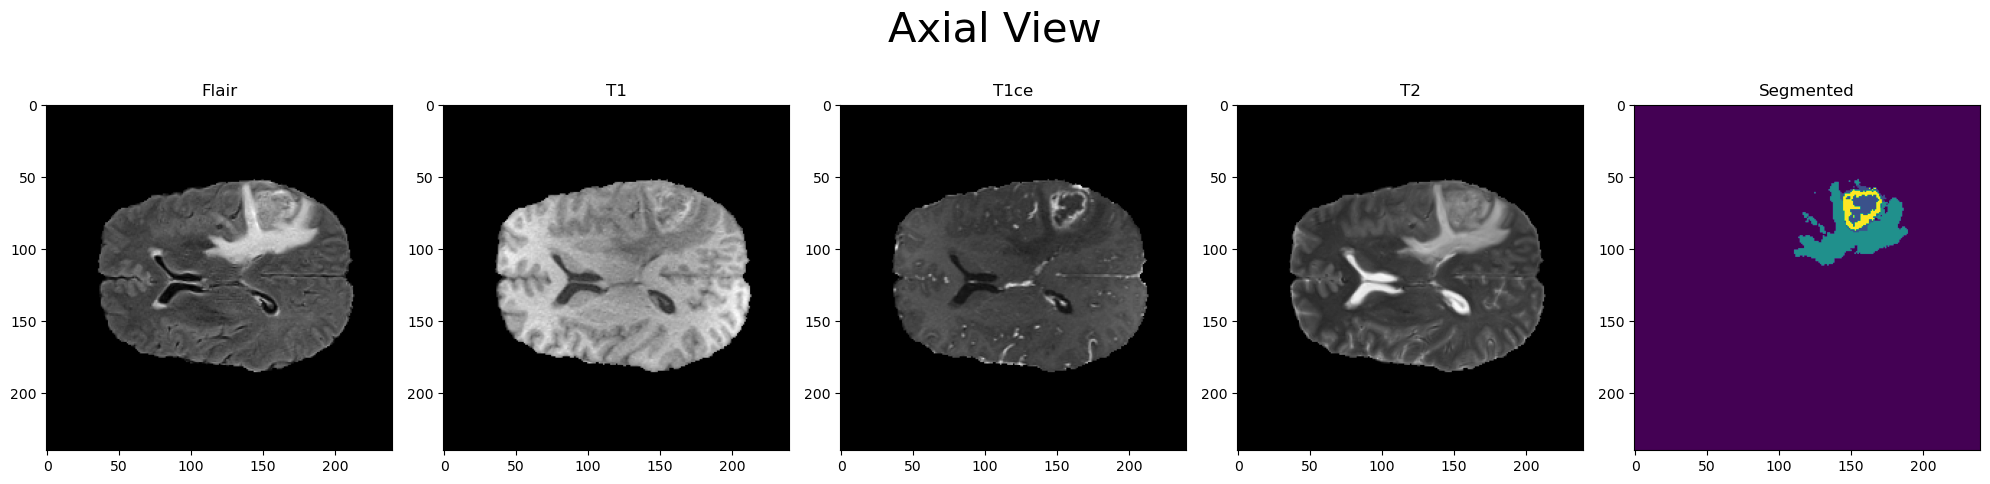

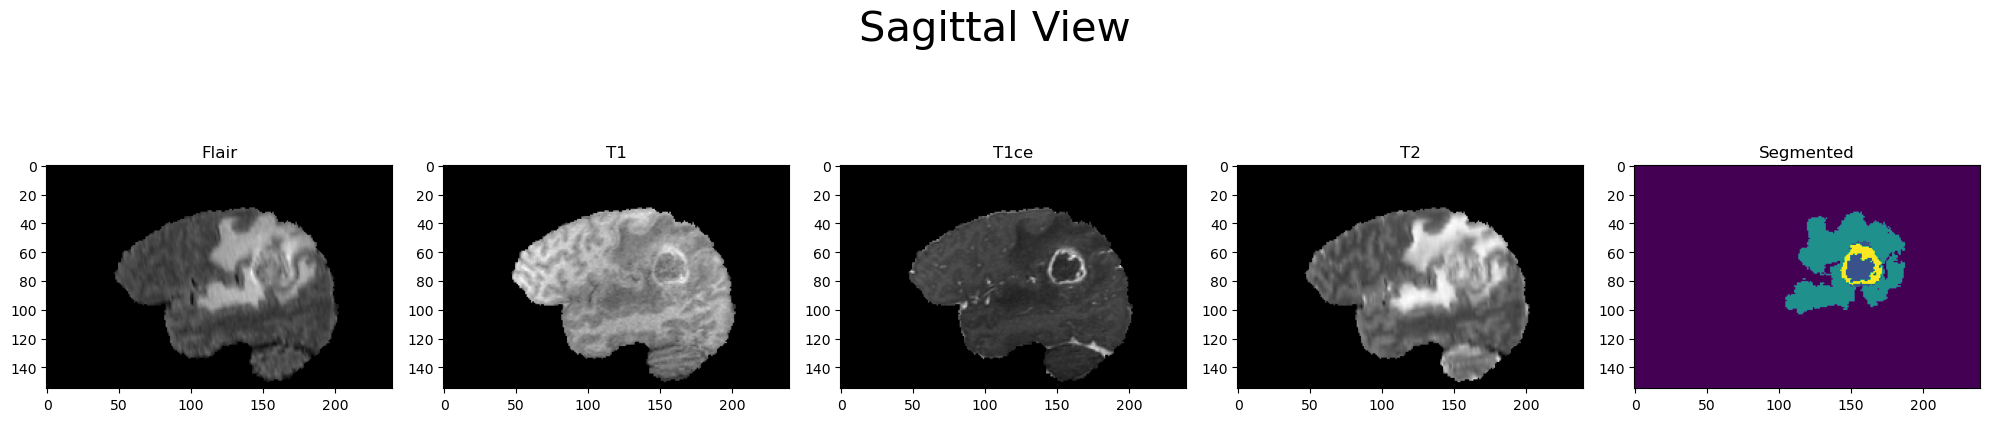

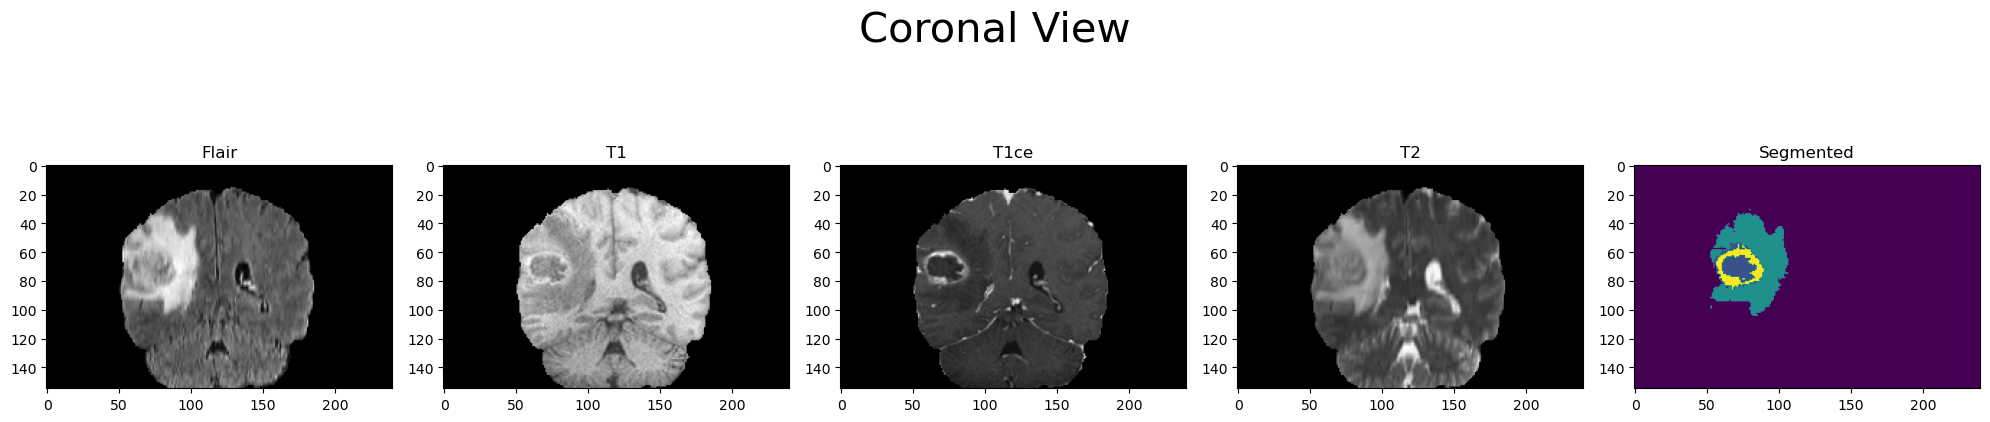

In [4]:
test_image_flair=nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
Image=Image_explorer
Image().Axial_View(layer=75);
Image().Sagittal_View(layer=75)
Image().Coronal_View(layer=150)

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(128,128,128),shuffle=False,channels=3,num_class=4):
        'Initialization'
        self.dim = dim
        self.n_channels=channels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.num_class=num_class
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        X=np.zeros((self.batch_size,*(self.dim),self.n_channels))
        Y=np.zeros((self.batch_size,*(self.dim),self.num_class))
        for i, ID in enumerate(list_IDs_temp):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            data_path = os.path.join(case_path, f'{ID}_t1.nii')
            t1 = nib.load(data_path).get_fdata()
            st1=MinMaxScaler()
            t1=st1.fit_transform(t1.reshape(-1,t1.shape[-1])).reshape(t1.shape)
            data_path = os.path.join(case_path, f'{ID}_flair.nii')
            flair = nib.load(data_path).get_fdata()
            stflair=MinMaxScaler()
            flair=stflair.fit_transform(flair.reshape(-1,flair.shape[-1])).reshape(flair.shape)
            data_path = os.path.join(case_path, f'{ID}_t1ce.nii')
            t1ce = nib.load(data_path).get_fdata()
            st1ce=MinMaxScaler()
            t1ce=st1ce.fit_transform(t1ce.reshape(-1,t1ce.shape[-1])).reshape(t1ce.shape)
            data_path = os.path.join(case_path, f'{ID}_seg.nii')
            seg = nib.load(data_path)
            x=np.stack([t1,flair,t1ce],axis=3)
            seg=np.array(seg.get_fdata())
            seg[seg==4]=3
            seg=keras.utils.to_categorical(seg,self.num_class)
            X[i]=x[56:184,56:184,13:141]#this slicing is important as GPU will run out of memory if we take the complete image
            Y[i]=seg[56:184,56:184,13:141]

        return X, Y

In [6]:
Train_ids = Name(Data_dir);
Train_ids=[t for t in Train_ids if t!='BraTS20_Training_355']
train,test=train_test_split(Train_ids,test_size=(1/4),random_state=42)
Train,Validation=train_test_split(train,test_size=(1/4),random_state=42)
Train_datagen=DataGenerator(Train,batch_size=1)
Val_datagen=DataGenerator(Validation,batch_size=1)

In [71]:
X,y=Train_datagen.__getitem__(30)

In [8]:
print(X.shape)
print(y.shape)

(1, 128, 128, 128, 3)
(1, 128, 128, 128, 4)


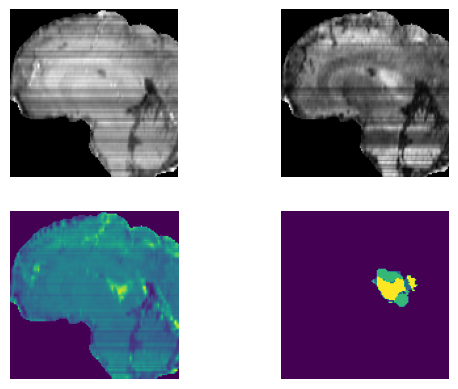

In [72]:
sample=0#checking the 2nd sample of first batch
yhat=y[sample]
yhat=np.argmax(yhat,axis=-1)
layer=64
plt.subplot(2,2,1)
plt.imshow(np.rot90(X[sample,layer,:,:,0]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(X[sample,layer,:,:,1]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(X[sample,layer,:,:,2]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

In [75]:
#original image
img_path=Train[29]
path=os.path.join(TRAIN_DATASET_PATH,img_path)
p=os.listdir(path)
t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
#test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

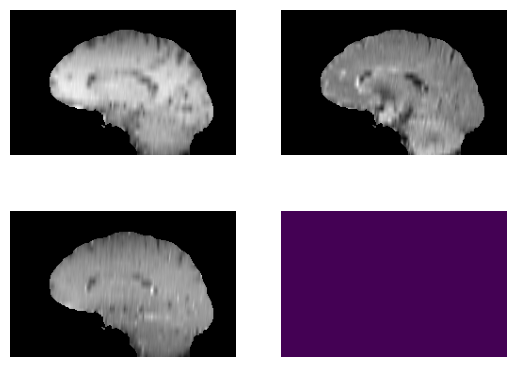

In [76]:
layer=136
plt.subplot(2,2,1)
plt.imshow(np.rot90(test_image_t1[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(test_image_flair[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(test_image_t1ce[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(test_seg[layer,:,:]))
plt.axis('off')
plt.show()

In [12]:
wt=np.array([0.25,0.25,0.25,0.25])
diceloss=sm.losses.DiceLoss(class_weights=wt)
focalloss=sm.losses.CategoricalFocalLoss()
totalloss=diceloss+(1*focalloss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

In [13]:
batch_size=1
lr=0.0001
optim=keras.optimizers.Adam(lr)
steps_per_epoch=len(Train)//batch_size
val_steps_per_epoch=len(Validation)//batch_size

In [14]:
# model=sm.Unet(backbone_name='efficientnetb0', input_shape=(128,128,128,3), classes=4, activation='softmax',encoder_weights='imagenet')
# model.compile(optimizer=optim,loss=totalloss,metrics=metrics)
# model.summary()

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=(3, 3, 3), activation='relu', padding='same'):
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_3d(input_shape=(128, 128, 128, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Middle
    conv4 = conv_block(pool3, 256)

    # Decoder
    up5 = layers.UpSampling3D(size=(2, 2, 2))(conv4)
    concat5 = layers.concatenate([conv3, up5], axis=-1)
    conv5 = conv_block(concat5, 128)

    up6 = layers.UpSampling3D(size=(2, 2, 2))(conv5)
    concat6 = layers.concatenate([conv2, up6], axis=-1)
    conv6 = conv_block(concat6, 64)

    up7 = layers.UpSampling3D(size=(2, 2, 2))(conv6)
    concat7 = layers.concatenate([conv1, up7], axis=-1)
    conv7 = conv_block(concat7, 32)

    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv7)

    model = Model(inputs, outputs, name='3D_UNet')
    return model

# Instantiate the model
model = unet_3d(input_shape=(128, 128, 128, 3), num_classes=4)

# Compile the model
model.compile(optimizer=optim, loss=totalloss, metrics=metrics)

# Display model summary
model.summary()


Model: "3D_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  2624        ['input_1[0][0]']                
                                8, 32)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  128        ['conv3d[0][0]']                 
 alization)                     8, 32)                                                      

In [16]:
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# def conv_block(x, filters, kernel_size=(3, 3, 3), activation='leakyrelu', padding='same'):
#     if activation == 'leakyrelu':
#         activation = layers.LeakyReLU(alpha=0.1)
#     x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
#     x = layers.BatchNormalization()(x)
#     return x

# def unet_3d(input_shape=(128, 128, 128, 3), num_classes=4):
#     inputs = layers.Input(input_shape)

#     # Encoder
#     conv1 = conv_block(inputs, 32)
#     pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

#     conv2 = conv_block(pool1, 64)
#     pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

#     conv3 = conv_block(pool2, 128)
#     pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

#     conv4 = conv_block(pool3, 256)
#     pool4 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv4)

#     conv5 = conv_block(pool4, 512)
#     pool5 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv5)

#     conv6 = conv_block(pool5, 1024)

#     # Decoder
#     up7 = layers.UpSampling3D(size=(2, 2, 2))(conv6)
#     concat7 = layers.concatenate([conv5, up7], axis=-1)
#     conv7 = conv_block(concat7, 512)

#     up8 = layers.UpSampling3D(size=(2, 2, 2))(conv7)
#     concat8 = layers.concatenate([conv4, up8], axis=-1)
#     conv8 = conv_block(concat8, 256)

#     up9 = layers.UpSampling3D(size=(2, 2, 2))(conv8)
#     concat9 = layers.concatenate([conv3, up9], axis=-1)
#     conv9 = conv_block(concat9, 128)

#     up10 = layers.UpSampling3D(size=(2, 2, 2))(conv9)
#     concat10 = layers.concatenate([conv2, up10], axis=-1)
#     conv10 = conv_block(concat10, 64)

#     up11 = layers.UpSampling3D(size=(2, 2, 2))(conv10)
#     concat11 = layers.concatenate([conv1, up11], axis=-1)
#     conv11 = conv_block(concat11, 32)

#     # Additional Convolutional Blocks
#     conv12 = conv_block(conv11, 16)
#     conv13 = conv_block(conv12, 8)

#     outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv13)

#     model = Model(inputs, outputs, name='3D_UNet')
#     return model

# # Instantiate the model
# model = unet_3d(input_shape=(128, 128, 128, 3), num_classes=4)

# # Compile the model
# model.compile(optimizer=optim, loss=totalloss, metrics=metrics)

# # Display model summary
# model.summary()


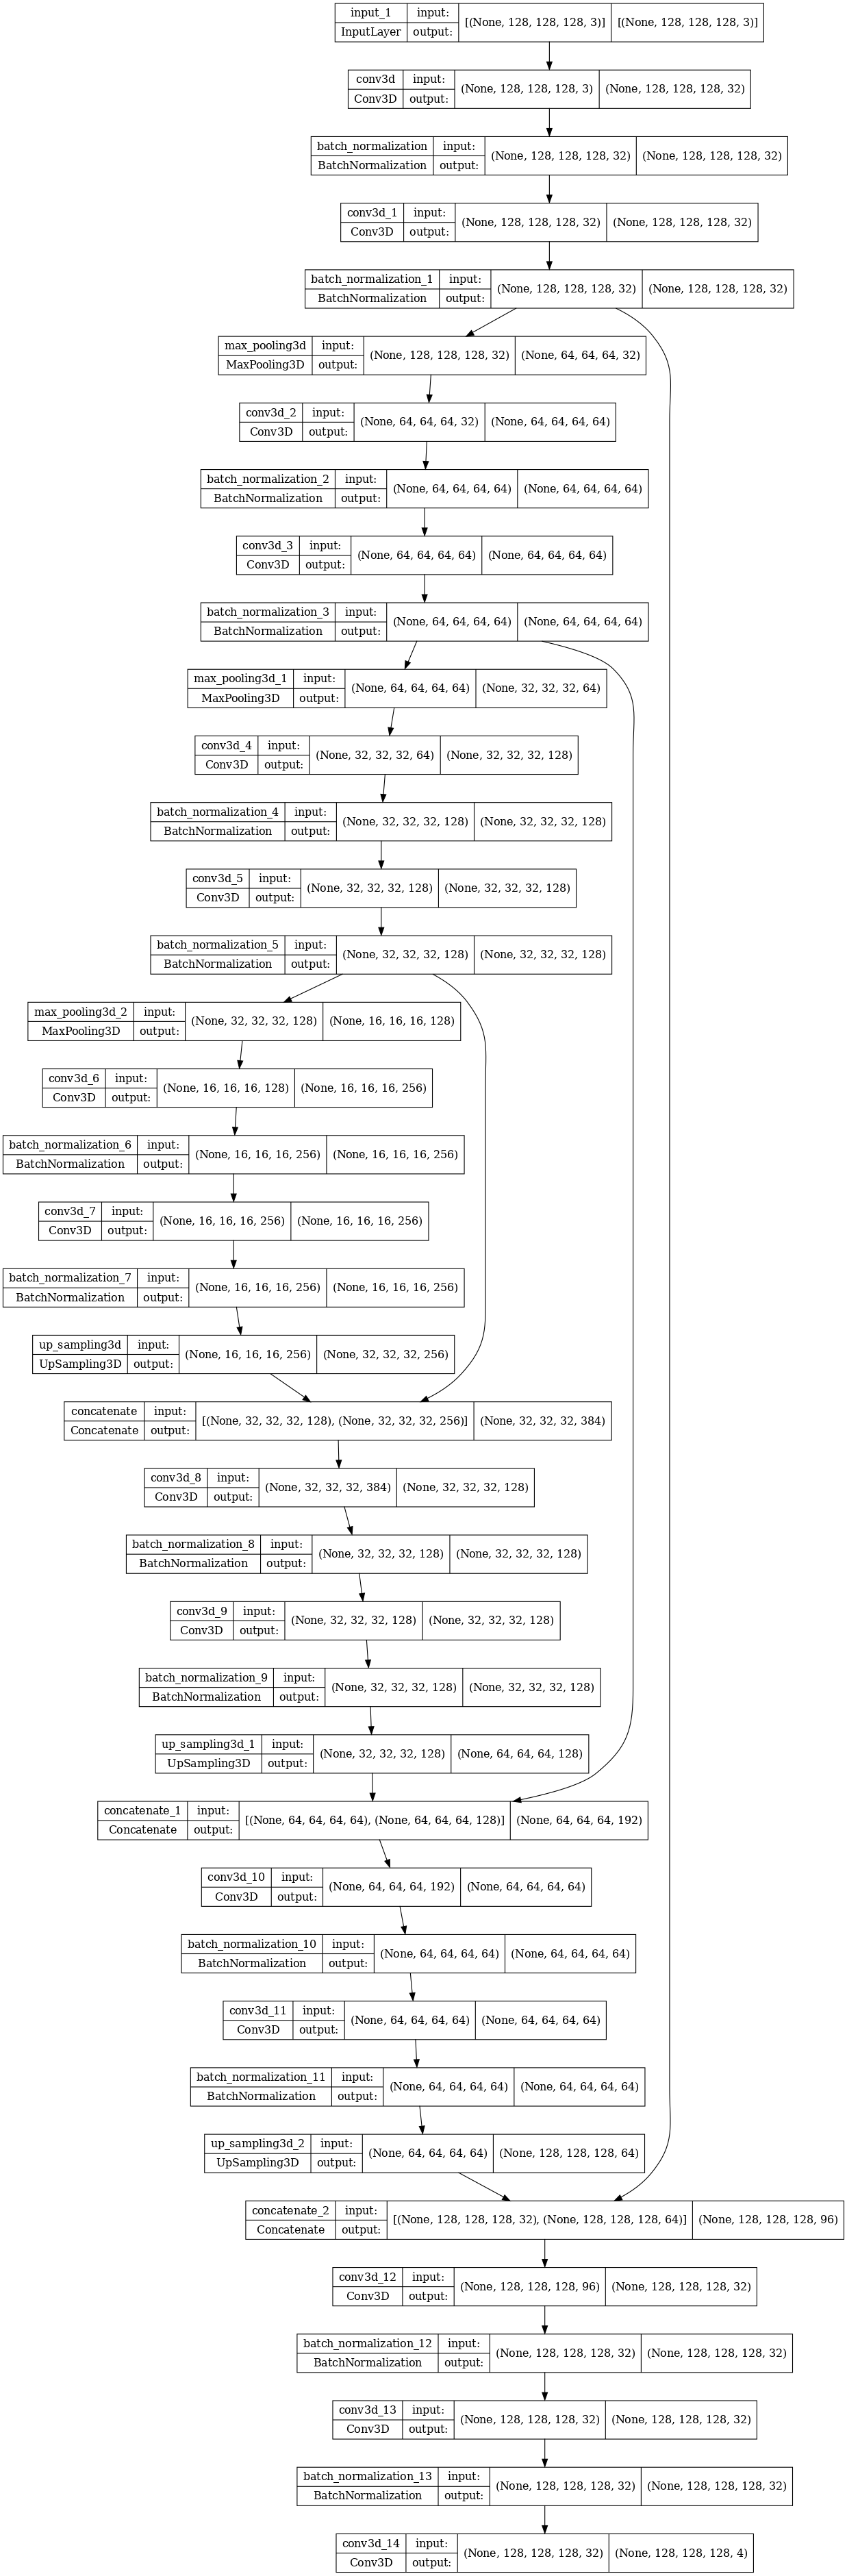

In [17]:
plot_model(model, show_shapes = True,expand_nested = True,dpi = 80)

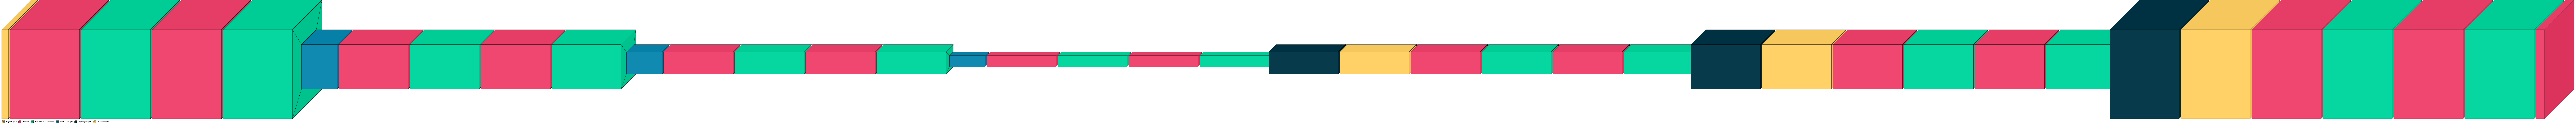

In [18]:
visualkeras.layered_view(model, legend=True)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [20]:
history=model.fit(Train_datagen,epochs=50,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch, callbacks = [early_stop])
# model.save('my_mdl.keras')

Epoch 1/50
207/207 [==============================] - 556s 3s/step - loss: 0.9871 - accuracy: 0.8499 - iou_score: 0.1663 - val_loss: 0.9576 - val_accuracy: 0.9510 - val_iou_score: 0.2580
Epoch 2/50
207/207 [==============================] - 305s 1s/step - loss: 0.9602 - accuracy: 0.9502 - iou_score: 0.3905 - val_loss: 0.9869 - val_accuracy: 0.9041 - val_iou_score: 0.3841
Epoch 3/50
207/207 [==============================] - 304s 1s/step - loss: 0.9448 - accuracy: 0.9631 - iou_score: 0.4927 - val_loss: 0.9344 - val_accuracy: 0.9689 - val_iou_score: 0.3938
Epoch 4/50
207/207 [==============================] - 313s 2s/step - loss: 0.9313 - accuracy: 0.9682 - iou_score: 0.5244 - val_loss: 1.0047 - val_accuracy: 0.8834 - val_iou_score: 0.4202
Epoch 5/50
207/207 [==============================] - 314s 2s/step - loss: 0.9165 - accuracy: 0.9729 - iou_score: 0.5565 - val_loss: 0.9136 - val_accuracy: 0.9638 - val_iou_score: 0.4534
Epoch 6/50
207/207 [==============================] - 310s 1s/ste

**Higher Round trainings**

In [21]:
# UNet_3D=load_model('/kaggle/input/unet3d-round2/UNet_3D_best_model_round2_128.keras',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [22]:
# UNet_3D.summary()

In [23]:
# plot_model(UNet_3D, show_shapes = True,expand_nested = True,dpi = 80)

In [24]:
# visualkeras.layered_view(UNet_3D, legend=True)

Note the actual model is trained on more than 100 epochs

In [25]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('UNet_3D_best_model_round3_128.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [26]:
# #30epochs
# history=UNet_3D.fit(Train_datagen,epochs=40,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch,callbacks=[es,mc])
# #my_model.save('UNet_3D_128_128_128_round_1.keras')

In [27]:
# UNet_3D=load_model('/kaggle/input/trained-unet-3d/UNet_3D_best_model_round3_128.keras',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

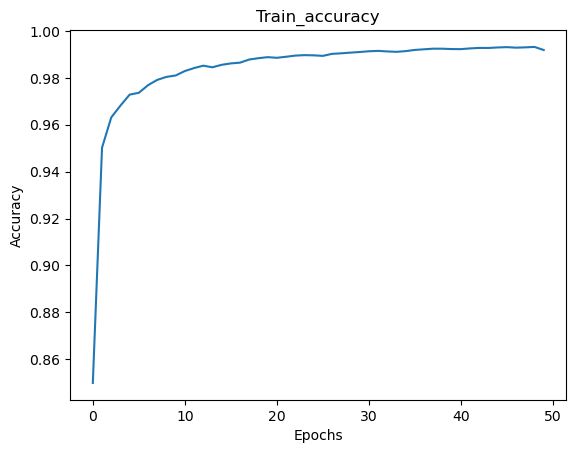

In [28]:
plt.title('Train_accuracy')
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

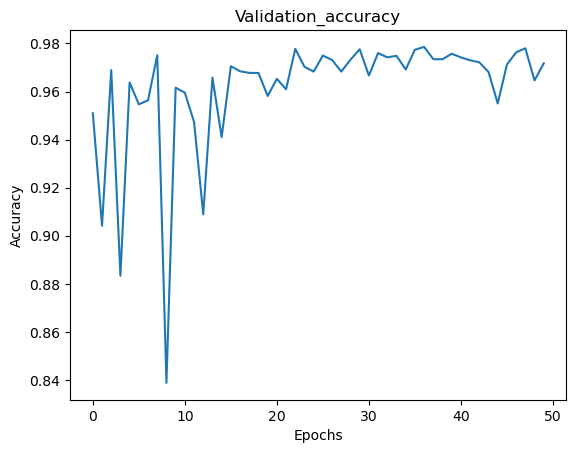

In [29]:
plt.title('Validation_accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

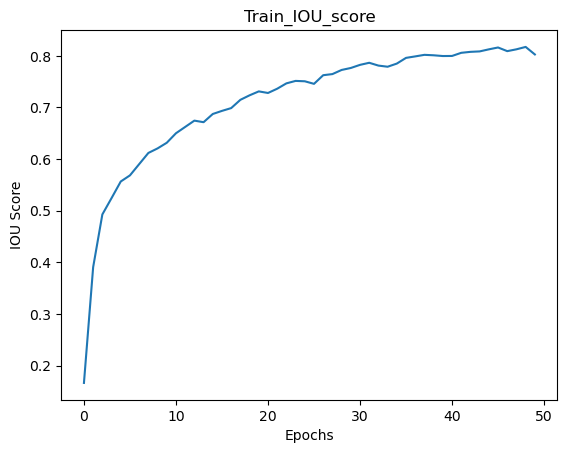

In [30]:
plt.title('Train_IOU_score')
plt.plot(history.history['iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

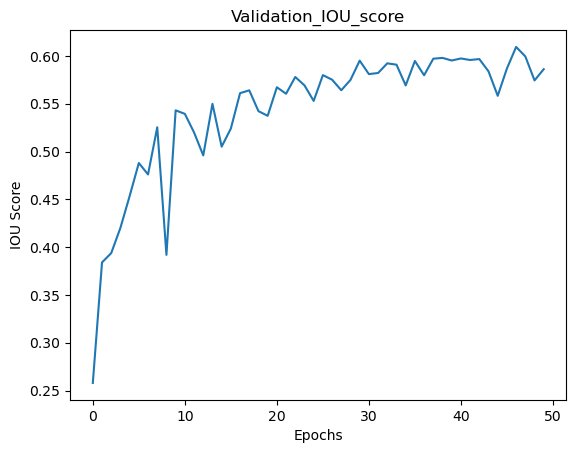

In [31]:
plt.title('Validation_IOU_score')
plt.plot(history.history['val_iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

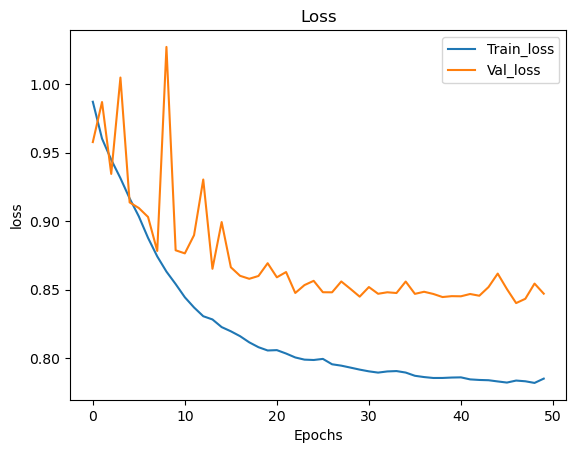

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'],label='Train_loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [48]:
X,y=Val_datagen.__getitem__(15)#fetching the first batch

In [49]:
y_pred=model.predict(X)

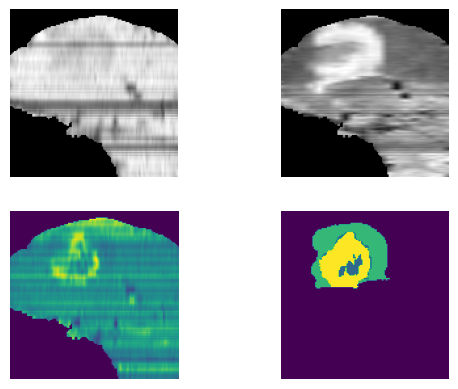

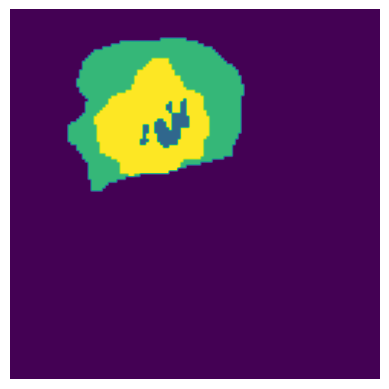

In [52]:
sample=0#checking the 2nd sample of first batch
yhat=y[sample]
yhat=np.argmax(yhat,axis=-1)
layer=80
plt.subplot(2,2,1)
plt.imshow(np.rot90(X[sample,layer,:,:,0]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(X[sample,layer,:,:,1]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(X[sample,layer,:,:,2]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

yhat=np.argmax(y_pred[0],axis=-1)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

In [ ]:
from IPython.display import FileLink
import os
os.chdir(r'/kaggle/working/')
FileLink(r'/kaggle/working/UNet_3D_best_model_round3_128.keras')

In [ ]:
# model.save('saved_model.keras')

In [77]:
model.save_weights('saved_model.h5')